I just want to test if I understood PennyLane's instructions right from [this link](https://pennylane.ai/qml/demos/tutorial_how_to_use_noise_models).

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
import argparse
qml.QubitStateVector = qml.StatePrep

from variational_lse_solver import VarLSESolver


"""
To run this script you need the following packages:
- PennyLane (but the latest version does not have the QubitStateVector class (which is needed), so we redefine it above)
- Numpy < 2: need to install something like numpy 1.26.4
- Python 3.12
- torch 2.2.2
"""

"pip install pennylane numpy~=1.26.4 torch~=2.2.2 variational_lse_solver ipykernel matplotlib"


'pip install pennylane numpy~=1.26.4 torch~=2.2.2 variational_lse_solver ipykernel matplotlib'

In [23]:
@qml.BooleanFn
def rx_cond(op):
    return isinstance(op, qml.RX) and np.abs(op.parameters[0]) < 1.0

# Combine this arbitrary conditional with a wire-based conditional
rx_and_wires_cond = rx_cond & qml.noise.wires_in([0, 1])
for op in [qml.RX(0.05, wires=[0]), qml.RX(2.34, wires=[1]), qml.RX(0.05, wires=[1]),qml.RX(0.05, wires=[2])]:
    print(f"Result for {op}: {rx_and_wires_cond(op)}")

Result for RX(0.05, wires=[0]): True
Result for RX(2.34, wires=[1]): False
Result for RX(0.05, wires=[1]): True
Result for RX(0.05, wires=[2]): False


In [13]:
depol_error = qml.noise.partial_wires(qml.DepolarizingChannel, 0.01)

op = qml.X('w1') # Example gate operation
print(f"Error for {op}: {depol_error(op)}")

Error for X('w1'): DepolarizingChannel(0.01, wires=['w1'])


Creating noise model

In [14]:
fcond1, noise1 = rx_and_wires_cond, depol_error

In [15]:
fcond2 = qml.noise.op_eq(qml.StatePrep)

def noise2(op, **kwargs):
    for wire in op.wires:
        qml.ThermalRelaxationError(0.1, kwargs["t1"], kwargs["t2"], kwargs["tg"], wire)

In [16]:
fcond3 = qml.noise.op_eq("Hadamard") & qml.noise.wires_in([0, 1])

def noise3(op, **kwargs):
    qml.RX(np.pi / 16, op.wires)
    qml.apply(op)
    qml.RY(np.pi / 8, op.wires)

In [17]:
metadata = dict(t1=0.02, t2=0.03, tg=0.001)  # times unit: sec
noise_model = qml.NoiseModel(
    {fcond1: noise1, fcond2: noise2, fcond3: noise3}, **metadata
)
print(noise_model)

NoiseModel({
    rx_cond & WiresIn([0, 1]): DepolarizingChannel(p=0.01)
    OpEq(StatePrep): noise2
    OpEq(Hadamard) & WiresIn([0, 1]): noise3
}, t1 = 0.02, t2 = 0.03, tg = 0.001)


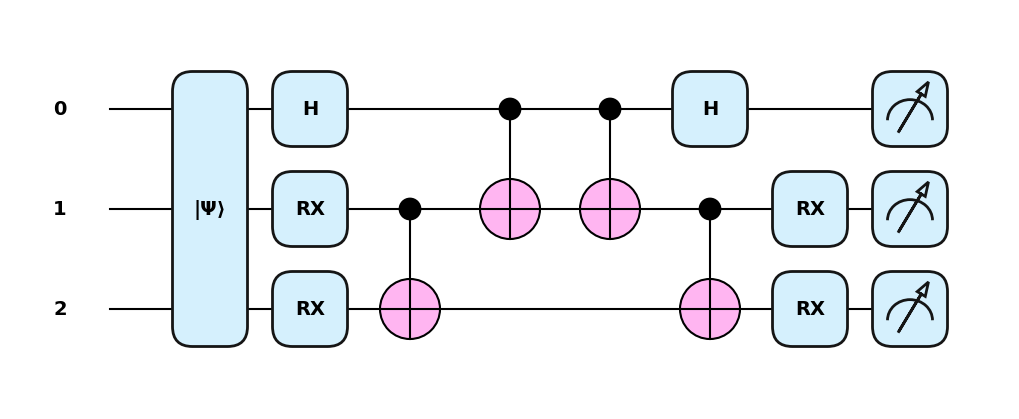

In [18]:
qml.drawer.use_style("pennylane")
dev = qml.device("default.mixed", wires=3)
init_state = np.random.RandomState(42).rand(2 ** len(dev.wires))
init_state /= np.linalg.norm(init_state)

def circuit(theta, phi):
    # State preparation
    qml.StatePrep(init_state, wires=[0, 1, 2])

    # Evolve state
    qml.Hadamard(0)
    qml.RX(theta, 1)
    qml.RX(phi, 2)
    qml.CNOT([1, 2])
    qml.CNOT([0, 1])

    # De-evolve state
    qml.CNOT([0, 1])
    qml.CNOT([1, 2])
    qml.RX(-phi, 2)
    qml.RX(-theta, 1)
    qml.Hadamard(0)
    return qml.state()

theta, phi = 0.21, 0.43
ideal_circuit = qml.QNode(circuit, dev)
qml.draw_mpl(ideal_circuit)(theta, phi)
plt.show()


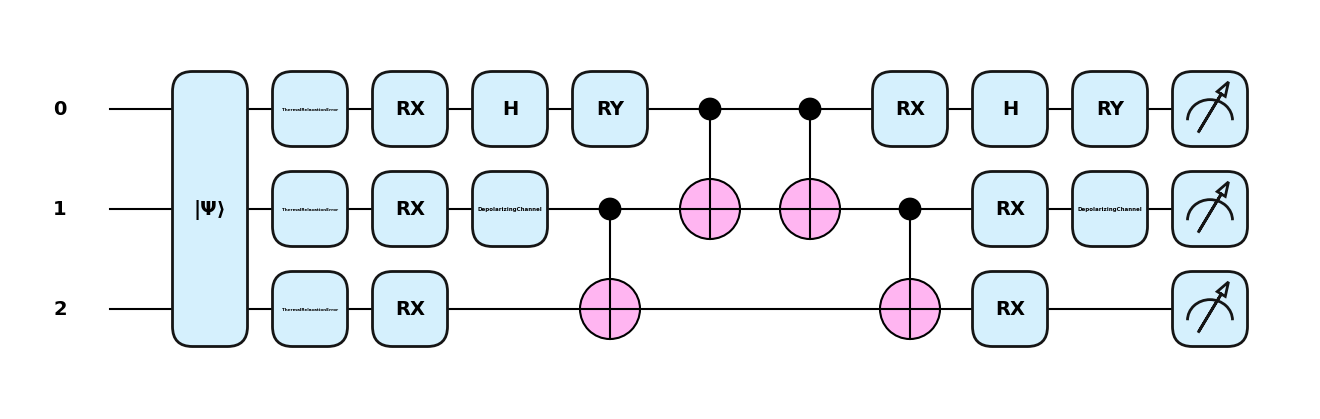

In [19]:
noisy_circuit = qml.add_noise(ideal_circuit, noise_model)
qml.draw_mpl(noisy_circuit)(theta, phi)
plt.show()

The fidelity for the state obtained from the ideal circuit is $\approx1.0$, which is expected since our circuit effectively does nothing to the initial state. We see that this is not the case for the result obtained from the noisy simulation, due to the error operations inserted in the circuit.

In [20]:
init_dm = np.outer(init_state, init_state) # density matrix for the init_state
ideal_res = np.round(qml.math.fidelity(ideal_circuit(theta, phi), init_dm), 8)
noisy_res = np.round(qml.math.fidelity(noisy_circuit(theta, phi), init_dm), 8)

print(f"Ideal v/s Noisy: {ideal_res} and {noisy_res}")

Ideal v/s Noisy: 1.00000002 and 0.90174224
